<a href="https://colab.research.google.com/github/PWalis/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [1]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
1+1


2

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots
import numpy as np

import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
py.sign_in("IPython.Demo", "1fw3zw2o13")

In [56]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/titanic.csv', index_col=0)
print(df.head(),'\n')
print(df.columns)
print('Number of NaN in sex column:', df.sex.isnull().sum())



   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True   

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')
Number of NaN in sex column:

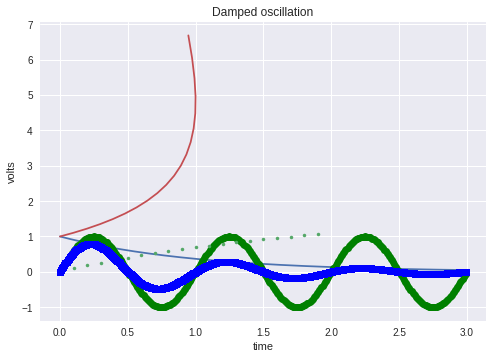

In [28]:
fig1 = plt.figure()
# Make a legend for specific lines.
import matplotlib.pyplot as plt
import numpy as np


t1 = np.arange(0.0, 2.0, 0.1)
t2 = np.arange(0.0, 3.0, 0.008)

# note that plot returns a list of lines.  The "l1, = plot" usage
# extracts the first element of the list into l1 using tuple
# unpacking.  So l1 is a Line2D instance, not a sequence of lines
l1, = plt.plot(t2, np.exp(-t2))
l2, l3 = plt.plot(t2, np.sin(2 * np.pi * t2), '--go', t1, np.log(1 + t1), '.')
l4, = plt.plot(t2, np.exp(-t2) * np.sin(2 * np.pi * t2), 'rs-.', color='b')
l5, = plt.plot(np.sin(t1), np.exp(t1))

plt.xlabel('time')
plt.ylabel('volts')
plt.title('Damped oscillation')

plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




So I just found a jupyter notebook with some neat looking graphs. I made a few changes to some numbers and changed the color of one of the waves. I also created a new line l5, to try and understand what's happening to the other lines. 
The most challenging part was finding something that looked intersting and simple.
In this particular notebook they're using Plotly which i've never heard of but it allows you to further edit and examine the graph, which could be usful at some point. 
I definitely want see other techniques to visualizing data because it's very useful to convey trends and projections.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.